In [64]:
import time

import numpy as np
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt

from tqdm import tqdm
%matplotlib inline

Вспомогательные функции



In [65]:
def generate_array(n):
    return np.random.randint(0, 100, n).tolist()

def check(arr, left, right, tree_answer):
    return np.max(arr[left:right]) == tree_answer

def timeit(func):
    def wrapper(*args, **kwargs):
        times = []
        for _ in range(1000):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time() - start_time
        times.append(end_time)
        
        return result, np.mean(times)
    return wrapper

Дерево Отрезков

In [66]:
class SegmentTree:
    def __init__(self, arr):
        self.n = len(arr)
        self.tree = [float('inf')] * (4 * self.n)
        self.build_tree(arr, 0, 0, self.n - 1)
        self.ops = 0

    def build_tree(self, array, vertex_index, left, right):
        if left == right:
            self.tree[vertex_index] = array[left]
        else:
            mid = (left + right) // 2
            left_index = 2 * vertex_index + 1
            right_index = 2 * vertex_index + 2
            self.build_tree(array, left_index, left, mid)
            self.build_tree(array, right_index, mid + 1, right)
            self.tree[vertex_index] = min(self.tree[left_index], self.tree[right_index])


    def get_min(self, start, end):
        return self.range_min(0, 0, self.n - 1, start, end)
    
    def measure_metrics(self, n_iter=100):
        end = np.random.randint(self.n // 2, self.n)
        start = np.random.randint(0, end)
        
        ops_time = []
        for _ in range(n_iter):
            self.ops = 0
            self.range_min(0, 0, self.n - 1, start, end)
            ops_time.append(self.ops)
        return np.mean(ops_time).item()

    def range_min(self, tree_index, start, end, left, right):
        if left > end or right < start:
            return float('inf')
        self.ops += 1
        if left <= start and right >= end:
            return self.tree[tree_index]
        mid = (start + end) // 2

        left_max = self.range_min(2 * tree_index + 1, start, mid, left, min(right, mid))
        right_max = self.range_min(2 * tree_index + 2, mid + 1, end, max(left, mid + 1), right)
        return min(left_max, right_max)


Дерево Фенвика

In [67]:
class BinaryIndexedTree:
    def __init__(self, arr):
        self.n = len(arr)
        self.tree = [float('inf')] * (self.n + 1)
        for i in range(self.n):
            self.update(i, arr[i])
        self.ops = 0

    def update(self, i, val):
        i += 1
        while i <= self.n:
            self.tree[i] = min(self.tree[i], val)
            i += i & -i
            
    def measure_metrics(self, n_iter=100):
        end = np.random.randint(self.n // 2, self.n)
        
        ops_time = []
        for _ in range(n_iter):
            self.ops = 0
            self.get_min(end)
            ops_time.append(self.ops)
        return np.mean(ops_time).item()

    def get_min(self, i):
        i += 1
        min_val = float('inf')
        while i > 0:
            self.ops += 1
            min_val = min(min_val, self.tree[i])
            i -= i & -i
        return min_val

Эксперименты

In [68]:
st_time, bit_time = [], []
arrays_lens = np.array(list(range(int(10), int(1e6), 5000)))

for n in tqdm(arrays_lens):
    test_arr = generate_array(n)
    
    st = SegmentTree(test_arr)
    bit = BinaryIndexedTree(test_arr)
    
    ops = st.measure_metrics()
    st_time.append(ops)
    
    ops = bit.measure_metrics()
    bit_time.append(ops)

100%|██████████| 200/200 [03:30<00:00,  1.05s/it]


In [78]:
a = [1, 3, 10, 2, 6, 4, 9]

In [79]:
st = SegmentTree(a)
st.get_min(2, 5)

2

In [76]:
bit = BinaryIndexedTree([40,89,1,59,60,65,70,18,12,26])
bit.get_min(7)

1

In [69]:
def mapping(x_values, a, b): 
    return a * np.log2(b * x_values)

popt_st, _ = curve_fit(mapping, arrays_lens, st_time)
popt_bit, _ = curve_fit(mapping, arrays_lens, bit_time)

/var/folders/m4/qlrlw2m95xgccb5_jxs2qtq40000gn/T/ipykernel_18983/3954136706.py:2: RuntimeWarning: invalid value encountered in log2
  return a * np.log2(b * x_values)


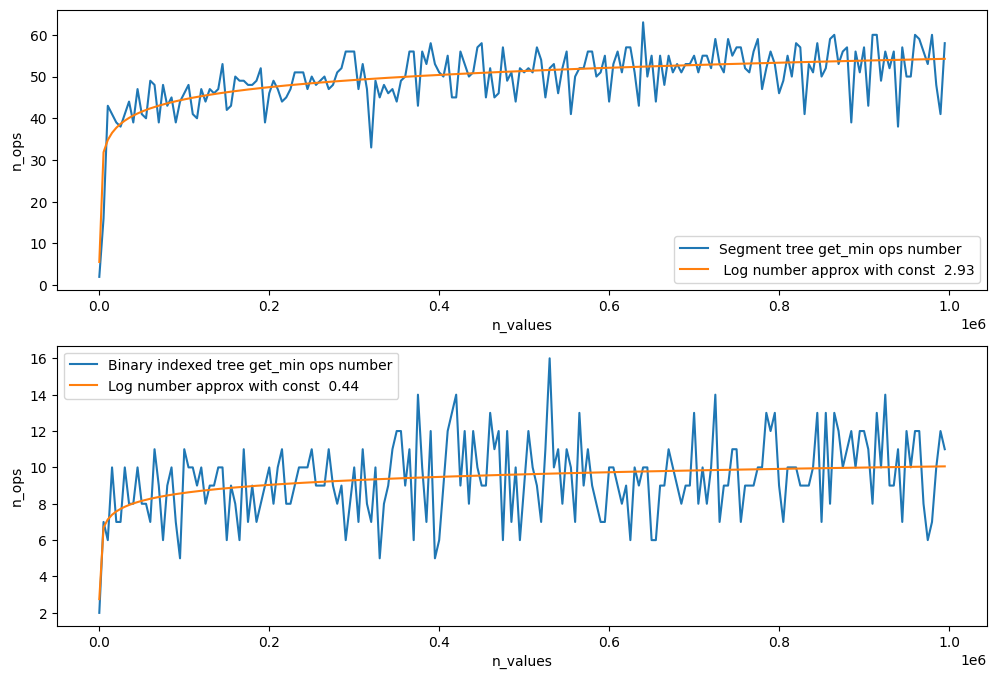

In [70]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

ax1.plot(arrays_lens, st_time, label = "Segment tree get_min ops number")
ax1.plot(arrays_lens, mapping(arrays_lens, *popt_st), label = f" Log number approx with const {popt_st[0]: .2f}")
ax1.set_xlabel('n_values')
ax1.set_ylabel('n_ops')
ax1.legend()

ax2.plot(arrays_lens, bit_time, label = "Binary indexed tree get_min ops number")
ax2.plot(arrays_lens, mapping(arrays_lens, *popt_bit), label = f"Log number approx with const {popt_bit[0]: .2f}")
ax2.set_xlabel('n_values')
ax2.set_ylabel('n_ops')
ax2.legend()

plt.show()